# Gaussian Scale Mixture model


- Orbán, Gergő, Pietro Berkes, József Fiser, and Máté Lengyel. 2016. “Neural Variability and Sampling-Based Probabilistic Representations in the Visual Cortex.” Neuron 92 (2): 530–43.
- Echeveste, Rodrigo, Laurence Aitchison, Guillaume Hennequin, and Máté Lengyel. 2020. “Cortical-like Dynamics in Recurrent Circuits Optimized for Sampling-Based Probabilistic Inference.” Nature Neuroscience 23 (9): 1138–49.
- Echeveste, Rodrigo, Guillaume Hennequin, and Máté Lengyel. 2017. “Asymptotic Scaling Properties of the Posterior Mean and Variance in the Gaussian Scale Mixture Model.” arXiv [q-bio.QM]. arXiv. https://doi.org/10.48550/ARXIV.1706.00925.

$$
\mathrm{P}\left(\mathbf{x}\mid\mathbf{y}, z\right)=\mathcal{N}\left(z \mathbf{A} \mathbf{y}, \sigma_{\mathbf{x}}^{2} \mathbf{I}\right)
$$

$$
\mathrm{P}\left(\mathbf{y}\right)=\mathcal{N}\left(\mathbf{0}, \mathbf{C}\right)
$$

$$
\begin{aligned}
\mathrm{P}(z \mid \mathbf{x}) &\propto \mathrm{P}(z) \mathcal{N}\left(0, z^{2} \mathbf{A C A}^{\top}+\sigma_{x}^{2} \mathbf{I}\right) \\
\mathrm{P}(\mathbf{y} \mid z, \mathbf{x})&=\mathcal{N}(\mu(z, \mathbf{x}), \Sigma(z))
\end{aligned}
$$

### 重み行列の作成

In [1]:
using PyPlot, LinearAlgebra, Random, Distributions
using PyPlot: matplotlib
Random.seed!(0)
rc("axes.spines", top=false, right=false)

In [2]:
function gabor(x, y, θ, σ=1, λ=2, ψ=0)
    xθ = x * cos(θ) + y * sin(θ)
    yθ = -x * sin(θ) + y * cos(θ)
    return exp(-.5(xθ^2 + yθ^2)/σ^2) * cos(2π/λ * xθ + ψ)
end;

In [3]:
L = 16      # width/height of input image
dim_x = L^2 # dimension of the observed variable x
dim_y = 50  # dimension of the hidden variable y

A = zeros(dim_x, dim_y) # weight matrix
p = range(-3, 3, length=L) # position
for i in 1:dim_y
    θ = π * i/dim_y
    gb = gabor.(p', p, θ)
    gb /= norm(gb) + 1e-8 # normalization
    A[:, i] = gb[:] # flatten and save
end;

重み行列$\mathbf{A}$の一部を描画してみよう．

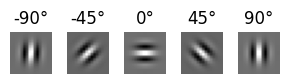

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\yamta\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


In [4]:
idx = trunc.(Int, range(1, 50, length=5))
figure(figsize=(3,1))
for i in 1:5
    subplot(1,5,i)
    title(string((i-1)*45-90)*"°")
    imshow(reshape(A[:, idx[i]], 16,16), cmap="gray")
    axis("off")
end
tight_layout()

### $y$の事前分布の分散共分散行列$\mathbf{C}$の作成
ガウス過程モデルが基本となっており，Kernelのcovariant matrixを事前分布にしている．Fourier baseを使っているのには重みに周期性があるため．位相は共通で、
フーリエ基底を用いて共分散行列を作る．

※実はこの部分の記述が論文中に全く無く，過去の研究にも記載がなかった．

In [5]:
# Produces a matrix whose columns are a set of discreete fourier base vectors        
function fourier_base(m, d=25)
    base = zeros(d, m)
    ω = 2π/m
    x = 0:m-1
    for i in 1:d
        n = trunc((i-1)/2)
        base[i, :] = (i-1)%2==0 ? cos.(n*ω*x) : sin.(n*ω*x) # true -> cos, false -> sin
        base[i, :] /= norm(base[i, :]) + 1e-8 # normalization
    end
    return base # transpose
end;

In [6]:
# Create an input covariance C with the right symmetry from the fourier base
function get_C_from_fourier(base, epsilon, decay_length)
    d, m = size(B)
    C = epsilon * I # regularizer
    for i in 1:d
        v = base[i, :]
        λ = 20*exp(-trunc((i-1)/2)/decay_length) # scaling
        C += λ * v * v'
    end
    C .-= 0.25    
    C .*= 4.0 / maximum(C)
    return Symmetric(C)
end

get_C_from_fourier (generic function with 1 method)

In [7]:
B = fourier_base(dim_y) # create the base matrix B

# build C from B
decay_length = dim_y / 50.0 # for the eigenvalues of C
epsilon = 0.01 # regularizer for C
C = get_C_from_fourier(B, epsilon, decay_length);

Pref. oriは最適方位 (preferred orientation)を意味する．

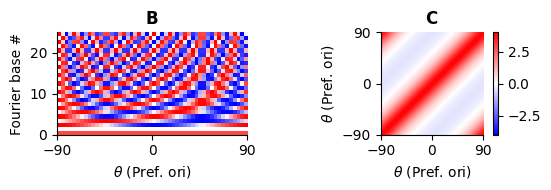

In [8]:
fig, ax = subplots(1, 2, figsize=(5.5, 2))
ax[1].set_title(L"$\mathbf{B}$")
ax[1].imshow(B, origin="lower", cmap="bwr", extent=(-90, 90, 0, 25), aspect="auto")
ax[1].set_xticks([-90,0,90]); 
ax[1].set_xlabel(L"$\theta$ (Pref. ori)"); ax[1].set_ylabel("Fourier base #")
ax[2].set_title(L"$\mathbf{C}$")
im = ax[2].imshow(C, origin="lower", cmap="bwr", vmin=-4, vmax=4, extent=(-90, 90, -90, 90))
ax[2].set_xticks([-90,0,90]); ax[2].set_yticks([-90,0,90]); 
ax[2].set_xlabel(L"$\theta$ (Pref. ori)"); ax[2].set_ylabel(L"$\theta$ (Pref. ori)")
fig.colorbar(im);
tight_layout()

### 事後分布等の関数
$x$を取得する関数を記述する．

In [9]:
function P_x_giv_yz(y, z, A, σx)
    x_mean = z*A*y
    noise = σx * randn(size(x_mean))
    return x_mean + noise
end

μ_z(z, σₓ², Σ_post, A, x) = (z/σₓ²) * Σ_post * A' * x
Σ_z(z, σₓ², C_inv, ATA) = inv(C_inv + (z^2 / σₓ²) * ATA)

function get_post_moments(x, z_MAP, σₓ², A, ATA, C_inv)
    Σ = Σ_z(z_MAP, σₓ², C_inv, ATA)
    μ = μ_z(z_MAP, σₓ², Σ, A, x)
    return μ, Σ
end

get_post_moments (generic function with 1 method)

In [10]:
log_P_z(z, k, θ) = logpdf.(Gamma(k, θ), z);

In [11]:
function P_z_giv_x(z_range, x, ACAT, σₓ², k, θ)
    n_contrasts = length(z_range)
    dim_x = length(x)
    log_p = zeros(n_contrasts)
    x_mean = zeros(dim_x)
    dz = z_range[2] - z_range[1]
    for i in 1:n_contrasts
        Cov = z_range[i]^2 * ACAT + σₓ² * I
        log_p[i] = log_P_z(z_range[i], k, θ) + logpdf(MvNormal(x_mean, Symmetric(Cov)), x)
    end
    p = exp.(log_p .- maximum(log_p))
    p /= sum(p) * dz
    return p   
end

P_z_giv_x (generic function with 1 method)

### シミュレーション

In [12]:
ATA = A' * A
ACAT = A * C * A'

σₓ = 1.0 # Noise of the x process
σₓ² = σₓ^2
k, θ = 2.0, 2.0 # Parameter of the gamma dist. for z. (Shape, Scale)

y_mean = zeros(dim_y) # The mean is 0 for y
C_inv = inv(C); # We will need the inverse of C

入力データの作成

In [13]:
Z = [0.0, 0.5, 2.0];
n_targets = size(Z)[1]
y = rand(MvNormal(y_mean, Symmetric(C)), 1) # sampling from P(y)=N(0, C)
X = hcat(map((z) -> P_x_giv_yz(y, z, A, σₓ), Z)...)';

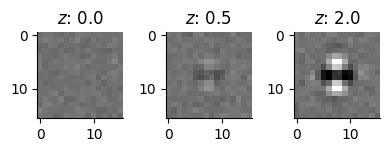

In [14]:
x_min, x_max = minimum(X), maximum(X)

figure(figsize=(4,2))
for alpha in 1:n_targets
    subplot(1, n_targets, alpha)
    title(L"$z$: "*string(Z[alpha]))
    imshow(reshape(X[alpha, :], 16, 16), 
        vmin=x_min, vmax=x_max, cmap="gray")
end
tight_layout()

`Symmetric(Cov)` or `Matrix(Hermitian(Cov)))`

In [15]:
# We compute the moments of the posteriors
μ_post = zeros(n_targets, dim_y)
σ_post = zeros(n_targets, dim_y)
Σ_post = zeros(n_targets, dim_y, dim_y)

z_range = range(0, 5.0, length=100) # range of z for MAP estimation
Z_MAP = zeros(n_targets) # MAP estimated z

for alpha in 1:n_targets
    p_z = P_z_giv_x(z_range, X[alpha, :], ACAT, σₓ², k, θ)

    # Moments at MAP contrast
    Z_MAP[alpha] = z_range[argmax(p_z)]
    μ_post[alpha, :], Σ_post[alpha, :, :] = get_post_moments(X[alpha, :], Z_MAP[alpha], σₓ², A, ATA, C_inv)
    σ_post[alpha, :] = sqrt.(diag(Σ_post[alpha, :, :]))
end

### 結果

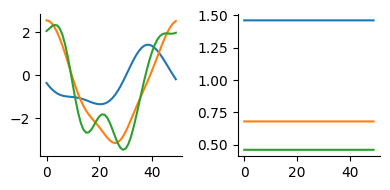

In [16]:
figure(figsize=(4,2))
subplot(1,2,1)
for alpha in 1:n_targets
    plot(μ_post[alpha, :])
end
subplot(1,2,2)
for alpha in 1:n_targets
    plot(σ_post[alpha, :])
end
tight_layout()

#### $\Sigma$

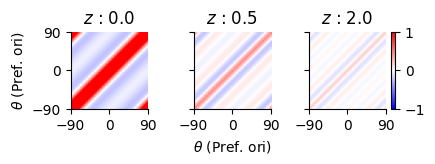

In [17]:
fig, ax = subplots(1, n_targets, figsize=(4.5, 1), sharey="all")
for alpha in 1:n_targets
    ax[alpha].set_title(L"$z$ : "*string(Z[alpha]))
    im = ax[alpha].imshow(Σ_post[alpha, :, :], origin="lower", cmap="bwr", vmin=-1, vmax=1, extent=(-90, 90, -90, 90))
    ax[alpha].set_xticks([-90,0,90]); ax[alpha].set_yticks([-90,0,90]);
    if alpha == 1
        ax[alpha].set_ylabel(L"$\theta$ (Pref. ori)")
    elseif alpha == 2 
        ax[alpha].set_xlabel(L"$\theta$ (Pref. ori)"); 
    end
end
fig.colorbar(im, ax=ax[n_targets]);

### output

In [18]:
"""
uTh = 1.9
thGam = 2
sigmaX = 0.7945
m = 10
alpha = 1.4
beta = 1.1
"""

"uTh = 1.9\nthGam = 2\nsigmaX = 0.7945\nm = 10\nalpha = 1.4\nbeta = 1.1\n"

In [19]:
membrane_potential(y, α=1.4) = sign(y) * abs(y)^α
firing_rate(u, β=1.1, m=10, uθ=1.9) = m * max.(0, u-uθ)^β;

In [20]:
nt = 100
u = zeros(n_targets, dim_y, nt)
for alpha in 1:n_targets
    μ = μ_post[alpha, :]
    Σ = Σ_post[alpha, :, :]
    d = MvNormal(μ, Symmetric(Σ))
    sample = rand(d, nt)
    u[alpha, :, :] = membrane_potential.(sample)
end

ToDo: 円を描く．
https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html

In [21]:
function confidence_ellipse(x, y, ax, n_std=3.5, alpha=0.2, facecolor="tab:red", edgecolor="tab:red")
    pearson = cor(x,y)
    rx, ry = sqrt(1 + pearson), sqrt(1 - pearson)
    ellipse = matplotlib.patches.Ellipse((0, 0), width=2*rx, height=2*ry, alpha=alpha, 
        facecolor=facecolor, edgecolor=edgecolor, zorder=0)
    scales = [std(x), std(y)] * n_std
    means = [mean(x), mean(y)]
    transf = matplotlib.transforms.Affine2D().rotate_deg(45).scale(scales...).translate(means...)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
end;

confidence_ellipse (generic function with 5 methods)

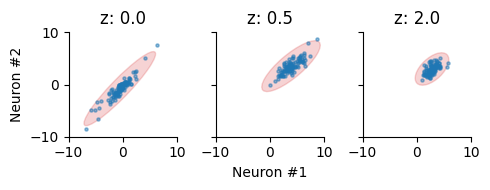

In [22]:
fig, ax = subplots(1, n_targets, figsize=(5, 2), sharey="all")
for alpha in 1:n_targets
    ax[alpha].set_title("z: "*string(Z[alpha]))
    ax[alpha].scatter(u[alpha, 1, :], u[alpha, 2, :], alpha=0.5, s=5)
    confidence_ellipse(u[alpha, 1, :], u[alpha, 2, :], ax[alpha])
    ax[alpha].set_xlim(-10,10)
    ax[alpha].set_ylim(-10,10)
    if alpha == 1
        ax[alpha].set_ylabel("Neuron #2")
    elseif alpha == 2 
        ax[alpha].set_xlabel("Neuron #1"); 
    end
end
tight_layout()